In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Надстройки!
import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

In [31]:
# Надстройки Дарины

from sklearn.linear_model import Lasso
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder
from sklearn.model_selection import GridSearchCV, KFold

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
ntrain = train.shape[0]

In [6]:
X_train, y_train = train.drop('SalePrice', axis=1), train['SalePrice']

In [7]:
y_train1 = np.log1p(y_train)

In [8]:
X_train.shape, test.shape

((1460, 80), (1459, 80))

In [9]:
X_full = pd.concat([X_train, test], axis=0)

# Проверим размерность датасета X_train после присоединения test
print("Размерность X_full после присоединения test:", X_full.shape)

Размерность X_full после присоединения test: (2919, 80)


In [10]:
# X_full

# Не забыть прологорифмировать таргет!!!

# Работа с пропусками в данных

In [11]:
#Количество пропусков
d1 = pd.DataFrame(data={'NaN_count': X_full.isna().sum()})
missing_data = d1[d1['NaN_count'] > 0]
missing_data = missing_data['NaN_count'].sort_values(ascending=False)

Text(0.5, 1.0, 'Доля пропущенных значений по каждому признаку')

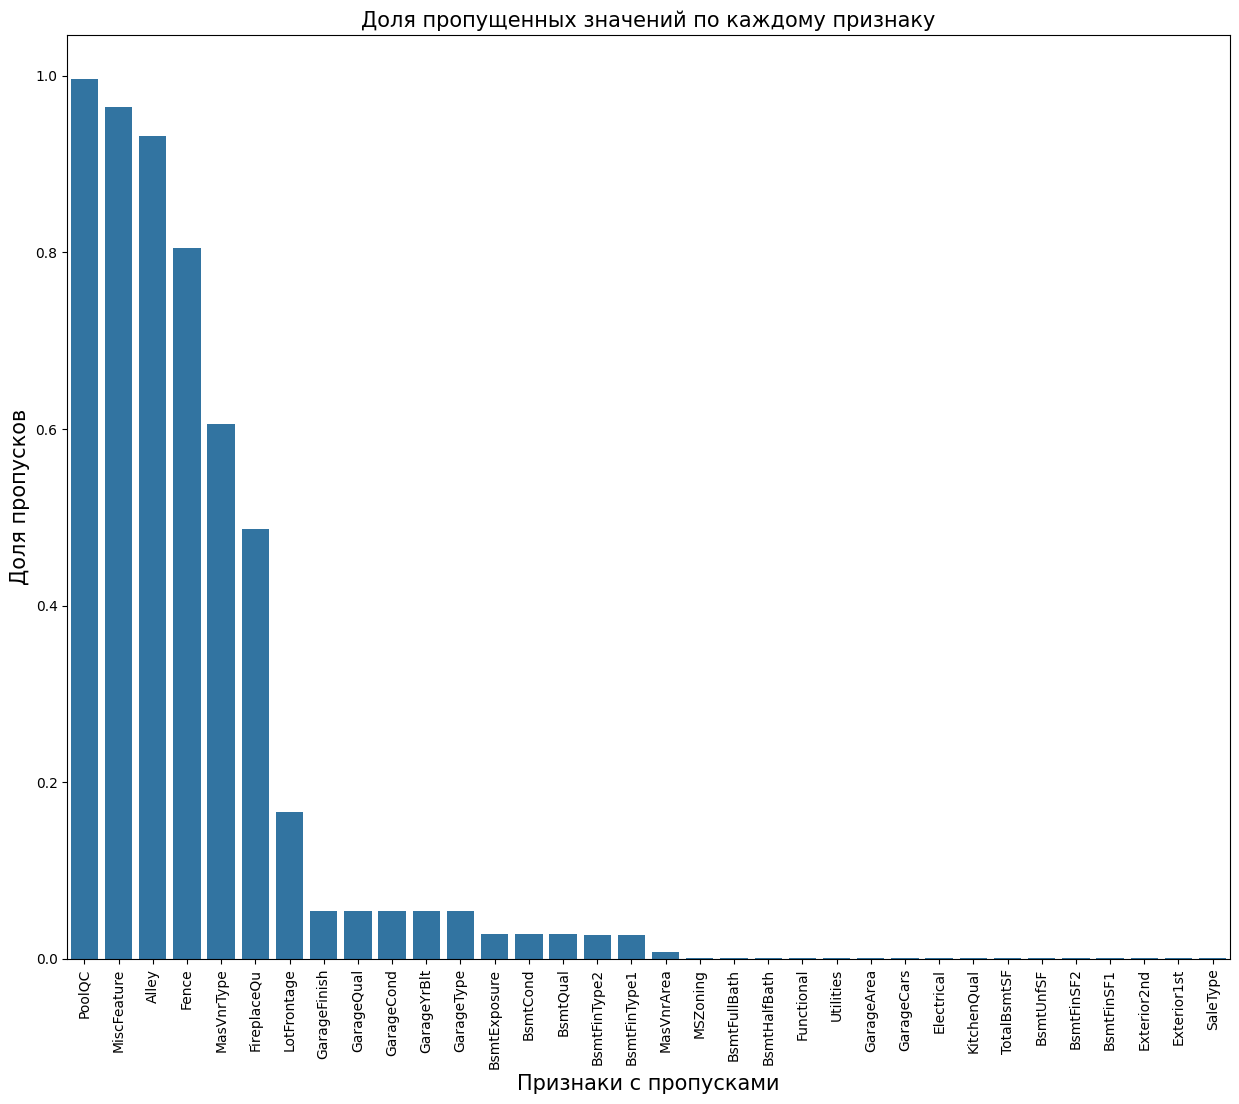

In [12]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(x=missing_data.index, y=missing_data/X_full.shape[0])
plt.xlabel('Признаки с пропусками', fontsize=15)
plt.ylabel('Доля пропусков', fontsize=15)
plt.title('Доля пропущенных значений по каждому признаку', fontsize=15)



In [13]:
num_features = train.select_dtypes(exclude='object')
cat_features = train.select_dtypes(include='object')

In [14]:
num_features.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [15]:
cat_features.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [16]:
len(missing_data.index)

34

In [17]:
#Из описания данных видно, что в некоторых столбцах  Nan означают не пропуск в данных, а отсутствие данного признака, заменим Nan на 0
# IMPUTE
IMPUTE_FEATURES_ZEROS = ['MasVnrArea', 'GarageYrBlt', 'BsmtFullBath', 'BsmtHalfBath', 'GarageArea', 'GarageCars',
                         'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1']
IMPUTE_FEATURES_NONE = ['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1', 'BsmtFinType2',
                         'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType','Fence', 'Alley', 'MiscFeature', 'PoolQC', 'Exterior2nd', 'FireplaceQu']
IMPUTE_FEATURES_MODA = ['Electrical', 'MSZoning', 'Heating', 'HeatingQC', 'Functional', 'Utilities', 'KitchenQual', 'Exterior1st', 'SaleType']
IMPUTE_FEATURES_MEAN = ['LotFrontage']

In [18]:
# drop_features = ['Id', 'Exterior2nd'] # Здесь пока помечаю столбцы, которые будем удалять


my_imputer = ColumnTransformer(
    transformers = [
        # ('drop_features', 'drop', drop_features),
        ('num_imputer', SimpleImputer(strategy='constant', fill_value=0), IMPUTE_FEATURES_ZEROS),
        ('cat_imputer', SimpleImputer(strategy='constant', fill_value='NA'), IMPUTE_FEATURES_NONE),
        ('moda_imputer', SimpleImputer(strategy='most_frequent'), IMPUTE_FEATURES_MODA),
        ('mean_imputer', SimpleImputer(strategy='mean'), IMPUTE_FEATURES_MEAN)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)    

In [19]:
filled_data = my_imputer.fit_transform(X_full)

In [20]:
d3 = pd.DataFrame(data={'NaN_count': filled_data.isna().sum()})
d3[d3['NaN_count'] > 0]

,NaN_count


In [21]:
train = X_full[:ntrain]
test = X_full[ntrain:]

In [22]:
filled_data['BsmtExposure'].value_counts()

BsmtExposure
No    1904
Av     418
Gd     276
Mn     239
NA      82
Name: count, dtype: int64

In [23]:
# определяем фичи для типов кодирования
ordinal_features = ['LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 
'Foundation', 'BsmtQual', 'BsmtCond',  'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical', 
'KitchenQual','Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC']


# Настройка one-hot кодирования
onehot_features = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities', 
'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Heating', 'CentralAir', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
'HalfBath', 'KitchenAbvGr', 'Fireplaces', 'GarageType', 'GarageCars', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

# порядок категорий для ordinal_features
ordinal_categories = [
    ['Reg', 'IR1', 'IR2', 'IR3'],  # Порядок для LotShape
    ['Gtl', 'Mod', 'Sev'], # Порядок для LandSlope
    ['Ex', 'Gd', 'TA', 'Fa', 'Po'],  # ExterQual 
    ['Ex', 'Gd', 'TA', 'Fa', 'Po'],  # ExterCond
    ['PConc', 'CBlock', 'BrkTil', 'Stone', 'Wood', 'Slab'],  # Foundation
    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],  # BsmtQual
    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],  # BsmtCond
    ['Gd', 'Av', 'Mn', 'No', 'NA'],  # BsmtExposure
    ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'], # BsmtFinType1
    ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'], # BsmtFinType2
    ['Ex', 'Gd', 'TA', 'Fa', 'Po'], # HeatingQC
    ['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix'], # Electrical 
    ['Ex', 'Gd', 'TA', 'Fa', 'Po'], #  KitchenQual
    ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'], # Functional
    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], # FireplaceQu
    ['Fin', 'RFn', 'Unf', 'NA'], # GarageFinish
    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], # GarageQual
    ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], # GarageCond 
    ['Ex', 'Gd', 'TA', 'Fa', 'NA'], #  PoolQC
]

In [24]:
scaler_and_encoder = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=ordinal_categories), ordinal_features),
        ('onehot', OneHotEncoder(sparse_output=False), onehot_features)
    ],
    remainder='passthrough'
)


In [25]:
filled_data = scaler_and_encoder.fit_transform(filled_data)

In [26]:
ss = StandardScaler()

filled_data = ss.fit_transform(filled_data)
filled_data.shape

(2919, 263)

In [27]:
train = filled_data[:ntrain]
test = filled_data[ntrain:]

In [28]:
correlation_matrix = train.corr()

In [29]:
high_corr = correlation_matrix[(correlation_matrix >= 0.1) & (correlation_matrix < 1.0)]

In [32]:
lasso = Lasso(alpha= 0.4)
lasso.fit(train, y_train)

/Users/darinaafanaseva/miniforge3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.997e+11, tolerance: 9.208e+08
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.4)

In [33]:
corr = pd.Series(dict(zip(train.columns, lasso.coef_))).sort_values(key=lambda x: abs(x), ascending=False)

to_drop = corr[corr < 100].tail(40).index.to_list()

In [34]:
train = train.drop(to_drop, axis = 1)